In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Geneset regulatory activity

In [91]:
# def read_gmt_file(gmt_path):
#     """
#     Read a GMT file and return a dictionary of gene sets.
    
#     Parameters:
#     -----------
#     gmt_path : str
#         Path to the GMT file
        
#     Returns:
#     --------
#     dict : Dictionary with gene set names as keys and gene lists as values
#     """
#     gene_sets = {}
#     with open(gmt_path, 'r') as f:
#         for line in f:
#             parts = line.strip().split('\t')
#             # First field is name, second is description (we'll skip it)
#             name = parts[0]
#             # Remaining fields are genes
#             genes = [g.upper() for g in parts[2:]]  # Convert to uppercase
#             gene_sets[name] = genes
    
#     return gene_sets
# # Load the GMT file
# kegg_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/KEGG_CELL_CYCLE.v2024.1.Hs.gmt'
# gobp_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_CELL_CYCLE.v2024.1.Hs.gmt'
# phase_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/CELL_CYCLE_PHASE.v2024.1.Hs.gmt'
# # create a list of genes from the dicts
# cell_cycle_kegg_genes = list(read_gmt_file(kegg_gmt_file)['KEGG_CELL_CYCLE'])
# cell_cycle_gobp_genes = list(read_gmt_file(gobp_gmt_file)['GOBP_CELL_CYCLE'])
# cell_cycle_phase_genes = list(read_gmt_file(phase_gmt_file)['CELL_CYCLE_PHASE'])
# display(len(cell_cycle_kegg_genes))
# display(len(cell_cycle_gobp_genes))
# display(len(cell_cycle_phase_genes))
# kegg_cell_cycle_in_object = check_if_gene_in_ndict(dictys_dynamic_object, cell_cycle_kegg_genes, return_index=True)
# print(f"Found {len(kegg_cell_cycle_in_object['present'])} genes")
# print(f"Missing {len(kegg_cell_cycle_in_object['missing'])} genes")
# print("Indices:", kegg_cell_cycle_in_object['indices'])
# # create a list of genes that are in the object from te indices dict keys
# kegg_cell_cycle_genes = list(kegg_cell_cycle_in_object['indices'].keys())
# display(len(kegg_cell_cycle_genes))
# # get lcpm chars for these genes

In [16]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)

# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()

# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))


In [17]:
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 68 genes
Missing 0 genes
Indices: {'SUB1': 9706, 'HLA-DPB1': 4195, 'HLA-DPA1': 4194, 'SSR1': 9582, 'CCSER2': 1534, 'HLA-DRB1': 4201, 'HLA-DMB': 4191, 'IGHM': 4421, 'PDE4D': 7027, 'TBC1D4': 9887, 'SLAMF7': 8987, 'LMAN1': 5269, 'HLA-DQA1': 4196, 'PAX5': 6943, 'PPIB': 7507, 'ELL2': 2979, 'ARFGAP3': 560, 'SEL1L3': 8763, 'TIAM1': 10070, 'PIKFYVE': 7235, 'SLC25A13': 9042, 'XBP1': 11200, 'HLA-A': 4187, 'UBAC2': 10759, 'HLA-B': 4188, 'IRF4': 4652, 'DEK': 2479, 'RNF213': 8355, 'CTSH': 2270, 'TRAM1': 10472, 'CD52': 1574, 'TRAM2': 10473, 'HLA-C': 4189, 'JCHAIN': 4730, 'EEA1': 2862, 'CEP128': 1733, 'HM13': 4210, 'FNDC3A': 3516, 'CIITA': 1884, 'TXNDC5': 10727, 'ANKRD28': 429, 'CD79A': 1587, 'MAN1A1': 5488, 'TXNDC11': 10722, 'MAPK1': 5543, 'CD99': 1598, 'PRDM1': 7604, 'HLA-DRA': 4200, 'SLA': 8982, 'ARNTL2': 665, 'GAB1': 3613, 'FNDC3B': 3517, 'CPEB4': 2131, 'HLA-DMA': 4190, 'BTG2': 1106, 'CD74': 1586, 'PIM2': 7239, 'GLCCI1': 3767, 'TNFAIP8': 10337, 'AFF3': 230, 'IQGAP2': 4638, 'MZB1': 6199, 'RU

## Expression dynamics of the genes

In [81]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
display(lf_lcpm_dcurve_pb)
# save lf_lcpm_dcurve_pb as pd dataframe pickle
lf_lcpm_dcurve_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_pb.pkl'))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
SUB1,8.369173,8.342922,8.316675,8.290565,8.264728,8.239300,8.214419,8.190218,8.166828,8.144376,...,9.775910,9.776817,9.777434,9.777781,9.777877,9.777740,9.777389,9.776839,9.776108,9.775210
HLA-DPB1,7.707154,7.701855,7.697406,7.693772,7.690903,7.688743,7.687227,7.686286,7.685850,7.685849,...,7.313053,7.306631,7.300444,7.294486,7.288749,7.283228,7.277917,7.272809,7.267899,7.263179
HLA-DPA1,7.836019,7.822874,7.810541,7.799045,7.788396,7.778596,7.769634,7.761492,7.754145,7.747563,...,7.815359,7.808516,7.801728,7.795003,7.788350,7.781776,7.775287,7.768892,7.762595,7.756403
SSR1,6.523533,6.521528,6.519301,6.516884,6.514318,6.511652,6.508942,6.506251,6.503650,6.501216,...,8.536705,8.543182,8.549409,8.555392,8.561137,8.566650,8.571938,8.577007,8.581862,8.586509
CCSER2,7.580596,7.597351,7.613368,7.628587,7.642959,7.656448,7.669024,7.680671,7.691377,7.701140,...,6.160481,6.156016,6.151944,6.148241,6.144879,6.141835,6.139085,6.136607,6.134379,6.132382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDK6,8.385617,8.361716,8.338023,8.314613,8.291569,8.268978,8.246929,8.225513,8.204820,8.184941,...,9.347596,9.351416,9.355139,9.358766,9.362296,9.365730,9.369069,9.372312,9.375460,9.378513
B2M,11.061204,11.068151,11.075225,11.082382,11.089579,11.096773,11.103927,11.111006,11.117980,11.124826,...,11.604844,11.606075,11.607320,11.608577,11.609843,11.611115,11.612390,11.613666,11.614941,11.616213
MED23,6.459328,6.478317,6.497180,6.515828,6.534174,6.552133,6.569618,6.586547,6.602841,6.618425,...,6.089822,6.088949,6.088203,6.087574,6.087055,6.086635,6.086307,6.086062,6.085893,6.085792
HLA-DQB1,7.321870,7.306017,7.291110,7.277183,7.264257,7.252338,7.241417,7.231477,7.222491,7.214426,...,6.262882,6.246902,6.231487,6.216632,6.202327,6.188564,6.175335,6.162630,6.150440,6.138754


In [83]:
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=1, stop=3, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
display(lf_lcpm_dcurve_gc)
# save lf_lcpm_dcurve_gc as pickle
lf_lcpm_dcurve_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_gc.pkl'))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
SUB1,8.751806,8.755932,8.760123,8.764327,8.768482,8.772520,8.776360,8.779917,8.783099,8.785808,...,8.056540,8.052341,8.048515,8.045024,8.041838,8.038926,8.036265,8.033830,8.031602,8.029561
HLA-DPB1,7.964996,7.970833,7.976372,7.981525,7.986194,7.990276,7.993664,7.996249,7.997923,7.998584,...,7.322783,7.327148,7.331616,7.336171,7.340795,7.345478,7.350207,7.354973,7.359768,7.364586
HLA-DPA1,8.035701,8.047535,8.059486,8.071446,8.083288,8.094867,8.106029,8.116605,8.126421,8.135299,...,7.690747,7.691697,7.692751,7.693896,7.695120,7.696415,7.697771,7.699182,7.700643,7.702147
SSR1,6.432338,6.435021,6.437857,6.440837,6.443948,6.447177,6.450508,6.453922,6.457400,6.460921,...,6.792865,6.789668,6.786607,6.783665,6.780829,6.778087,6.775430,6.772848,6.770334,6.767881
CCSER2,7.321726,7.312494,7.303103,7.293640,7.284211,7.274934,7.265943,7.257381,7.249401,7.242161,...,7.849513,7.855229,7.860655,7.865819,7.870745,7.875457,7.879975,7.884315,7.888494,7.892527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDK6,9.062461,9.056082,9.049243,9.041904,9.034028,9.025575,9.016510,9.006800,8.996418,8.985340,...,9.047924,9.046425,9.044850,9.043204,9.041494,9.039723,9.037896,9.036016,9.034087,9.032112
B2M,11.044637,11.042163,11.039463,11.036543,11.033417,11.030102,11.026621,11.023002,11.019276,11.015481,...,10.832573,10.831068,10.829700,10.828457,10.827326,10.826297,10.825360,10.824506,10.823729,10.823022
MED23,6.214579,6.207083,6.199515,6.191945,6.184455,6.177135,6.170085,6.163411,6.157225,6.151641,...,7.927566,7.936303,7.944312,7.951668,7.958438,7.964681,7.970449,7.975787,7.980737,7.985335
HLA-DQB1,7.483265,7.501091,7.519198,7.537443,7.555656,7.573649,7.591209,7.608110,7.624114,7.638976,...,6.236830,6.237243,6.238042,6.239181,6.240618,6.242319,6.244254,6.246395,6.248721,6.251209


#### Get the curvature of the lcpm expression of all lf genes

In [79]:
def get_curvature_of_expression(dcurve: pd.DataFrame, dtime: pd.Series):
    """
    Calculate the curvature of expression curves.
    """
    # First derivative (dx/dt)
    dx_dt = pd.DataFrame(
        np.gradient(dcurve, dtime, axis=1),
        index=dcurve.index,
        columns=dcurve.columns
    )
    # Second derivative (d2x/dt2)
    d2x_dt2 = pd.DataFrame(
        np.gradient(dx_dt, dtime, axis=1),
        index=dcurve.index,
        columns=dcurve.columns
    )
    return d2x_dt2   

In [84]:
# Apply to each gene in lf_lcpm_dcurve_pb
lf_lcpm_curvature_pb = get_curvature_of_expression(lf_lcpm_dcurve_pb, dtime_pb)
lf_lcpm_curvature_gc = get_curvature_of_expression(lf_lcpm_dcurve_gc, dtime_gc)
# save lf_lcpm_curvature_pb as pickle
lf_lcpm_curvature_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_pb.pkl'))
# save lf_lcpm_curvature_gc as pickle
lf_lcpm_curvature_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_gc.pkl'))

#### Choosing the genes which are dynamically divergent in lineages from the LFs

In [16]:
def find_dynamically_opposite_genes(gc_dchar: pd.DataFrame, pb_dchar: pd.DataFrame, min_effect: float = 0.1):
    """
    Find genes with opposite effects between GC and PB lineages by:
    1. Filtering out low effect genes
    2. Normalizing metrics within each condition separately
    3. Finding dominant effect (Terminal/Transient) for each gene in each condition
    4. Comparing signs of dominant effects
    
    Parameters:
    -----------
    gc_dchar, pb_dchar : pd.DataFrame
        DataFrames with 'Terminal logFC' and 'Transient logFC' columns
    min_effect : float
        Minimum absolute effect size threshold for filtering
    
    Returns:
    --------
    list : List of genes with opposite dominant effects between conditions
    """
    # Filter genes with low effect sizes in both conditions
    gc_filtered = gc_dchar[
        (abs(gc_dchar['Terminal logFC']) >= min_effect) | 
        (abs(gc_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    pb_filtered = pb_dchar[
        (abs(pb_dchar['Terminal logFC']) >= min_effect) | 
        (abs(pb_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    # Get common genes after filtering
    common_genes = list(set(gc_filtered.index) & set(pb_filtered.index))
    gc_filtered = gc_filtered.loc[common_genes]
    pb_filtered = pb_filtered.loc[common_genes]
    
    # Create normalized versions
    gc_norm = gc_filtered.copy()
    pb_norm = pb_filtered.copy()
    
    # Normalize GC metrics
    gc_terminal_abs = np.abs(gc_filtered['Terminal logFC'])
    gc_terminal_min = gc_terminal_abs.min()
    gc_terminal_max = gc_terminal_abs.max()
    gc_norm['Terminal logFC'] = (gc_terminal_abs - gc_terminal_min) / (gc_terminal_max - gc_terminal_min)
    gc_norm['Terminal logFC'] *= np.sign(gc_filtered['Terminal logFC'])
    
    gc_transient_abs = np.abs(gc_filtered['Transient logFC'])
    gc_transient_min = gc_transient_abs.min()
    gc_transient_max = gc_transient_abs.max()
    gc_norm['Transient logFC'] = (gc_transient_abs - gc_transient_min) / (gc_transient_max - gc_transient_min)
    gc_norm['Transient logFC'] *= np.sign(gc_filtered['Transient logFC'])
    
    # Normalize PB metrics
    pb_terminal_abs = np.abs(pb_filtered['Terminal logFC'])
    pb_terminal_min = pb_terminal_abs.min()
    pb_terminal_max = pb_terminal_abs.max()
    pb_norm['Terminal logFC'] = (pb_terminal_abs - pb_terminal_min) / (pb_terminal_max - pb_terminal_min)
    pb_norm['Terminal logFC'] *= np.sign(pb_filtered['Terminal logFC'])
    
    pb_transient_abs = np.abs(pb_filtered['Transient logFC'])
    pb_transient_min = pb_transient_abs.min()
    pb_transient_max = pb_transient_abs.max()
    pb_norm['Transient logFC'] = (pb_transient_abs - pb_transient_min) / (pb_transient_max - pb_transient_min)
    pb_norm['Transient logFC'] *= np.sign(pb_filtered['Transient logFC'])
    
    opposite_genes = []
    
    # Compare dominant effects for each gene
    for idx in common_genes:
        # Get normalized values
        gc_terminal = gc_norm.at[idx, 'Terminal logFC']
        gc_transient = gc_norm.at[idx, 'Transient logFC']
        pb_terminal = pb_norm.at[idx, 'Terminal logFC']
        pb_transient = pb_norm.at[idx, 'Transient logFC']
        
        # Determine dominant effect for each condition
        gc_dominant_val = gc_terminal if abs(gc_terminal) >= abs(gc_transient) else gc_transient
        pb_dominant_val = pb_terminal if abs(pb_terminal) >= abs(pb_transient) else pb_transient
        
        # Check if dominant effects have opposite signs
        if gc_dominant_val * pb_dominant_val < 0:
            opposite_genes.append(idx)
    return opposite_genes


In [17]:
opposite_genes = find_dynamically_opposite_genes(lf_lcpm_dchar_gc, lf_lcpm_dchar_pb, min_effect=0.3)
display(len(opposite_genes))

21

In [11]:
# order the opposite genes by keeping the upregulated genes first then downregulated genes
opposite_genes_ordered_pb = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Terminal logFC'], reverse=True)
opposite_genes_ordered_gc = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Terminal logFC'], reverse=True)


#### Genes with the most significant effect size changes per lineage

In [18]:
def get_top_terminal_effect_genes(dchar: pd.DataFrame, n_top: int = 15):
    """
    Get top genes based on their normalized effect sizes.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with 'Terminal logFC' and 'Transient logFC' columns
    n_top : int
        Number of top genes to return
    
    Returns:
    --------
    list : List of top genes sorted by combined normalized effect size
    """
    # Create normalized version of the dataframe
    norm_dchar = dchar.copy()
    
    # Normalize Terminal logFC
    terminal_abs = np.abs(dchar['Terminal logFC'])
    terminal_min = terminal_abs.min()
    terminal_max = terminal_abs.max()
    norm_dchar['Terminal logFC'] = (terminal_abs - terminal_min) / (terminal_max - terminal_min)
        
    # Sort by combined effect and get top genes
    top_genes = norm_dchar.nlargest(n_top, 'Terminal logFC').index.tolist()
    
    print(f"Top {n_top} genes by effect size:")
    for i, gene in enumerate(top_genes, 1):
        effect = norm_dchar.at[gene, 'Terminal logFC']
        print(f"{i}. {gene}: {effect:.3f}")
    
    return top_genes

In [19]:
# Usage:
top_pb_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_pb, n_top=10)
top_gc_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_gc, n_top=10)

Top 10 genes by effect size:
1. JCHAIN: 1.000
2. AFF3: 0.887
3. PRDM1: 0.859
4. FNDC3B: 0.822
5. TRAM2: 0.681
6. MZB1: 0.675
7. IGHM: 0.638
8. XBP1: 0.614
9. TXNDC5: 0.611
10. TXNDC11: 0.604
Top 10 genes by effect size:
1. JCHAIN: 1.000
2. MED23: 0.685
3. SLAMF7: 0.676
4. BTG2: 0.617
5. TBC1D4: 0.612
6. CD52: 0.609
7. PIM2: 0.576
8. ARNTL2: 0.544
9. RUNX2: 0.515
10. FNDC3B: 0.498


In [20]:
# take a union of top_genes and opposite_genes
dynamic_pb_genes = list(set(top_pb_genes + opposite_genes))
dynamic_gc_genes = list(set(top_gc_genes + opposite_genes))
display(len(dynamic_pb_genes))
display(len(dynamic_gc_genes))
# save the dynamic_pb_genes and dynamic_gc_genes
#np.save(os.path.join(output_folder, 'dynamic_pb_genes.npy'), dynamic_pb_genes)
#np.save(os.path.join(output_folder, 'dynamic_gc_genes.npy'), dynamic_gc_genes)


30

24

In [15]:
# order the dynamic_pb_genes by the switching time
dynamic_pb_genes_ordered = sorted(dynamic_pb_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Switching time'])
dynamic_gc_genes_ordered = sorted(dynamic_gc_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Switching time'])

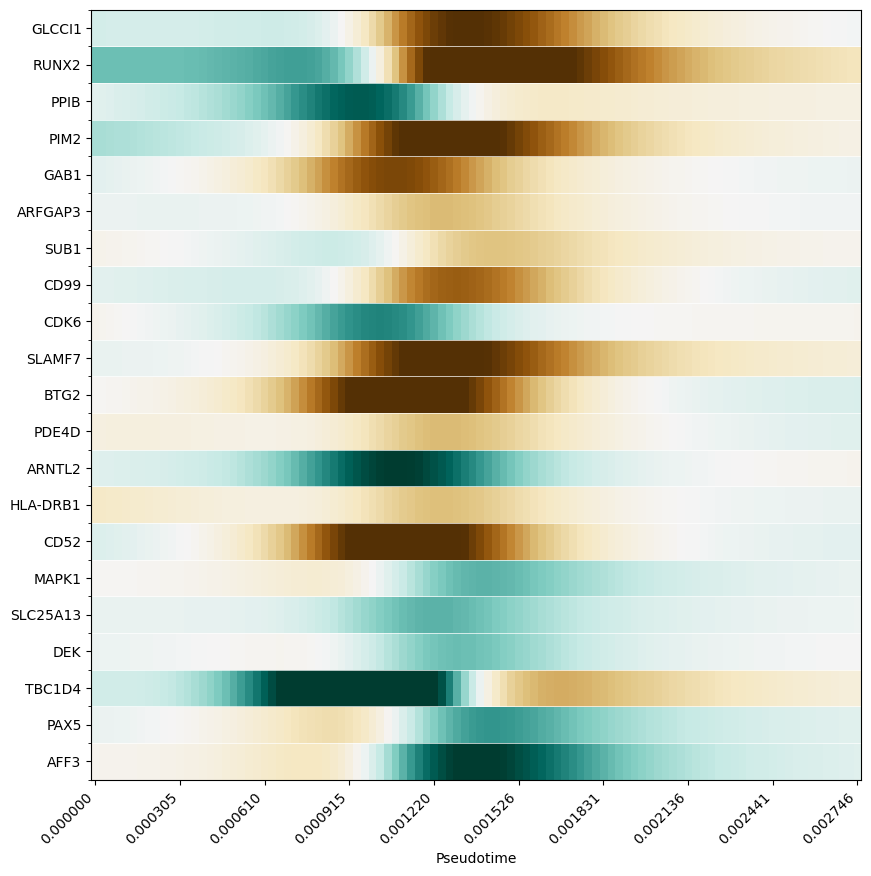

In [18]:
# Create figure for up-regulated genes
fig, ax = plt.subplots(figsize=(10, 10))
# Get genes from the up_regulated category
#transient_down_genes = lf_classifications['transient_down']
# Plot expression gradient for up-regulated genes
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=opposite_genes_ordered_pb,
    num=100,
    dist=0.0005,
    ax=ax,
    cmap="BrBG",
    figsize=(10, 0.3)
)

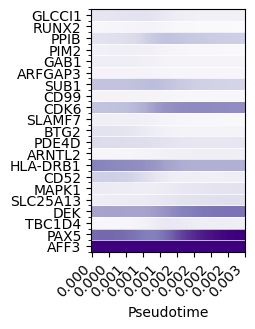

In [17]:
fig, ax, cmap = fig_expression_linear_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=opposite_genes_ordered_pb,
    num=100,
    dist=0.0005,
    cmap='Purples'
)
plt.show()


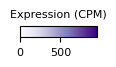

In [18]:
# Create matching colorbar
from dictys.plot import colorbar
fs = 8  # font size to match fig_discover style

ans2 = colorbar(
    cmap, 
    orientation='horizontal',
    figsize=(1, 0.15),
    title='Expression (CPM)',
    title_fontsize=fs
)
ans2[1].tick_params(axis='x', labelsize=fs)
plt.show()

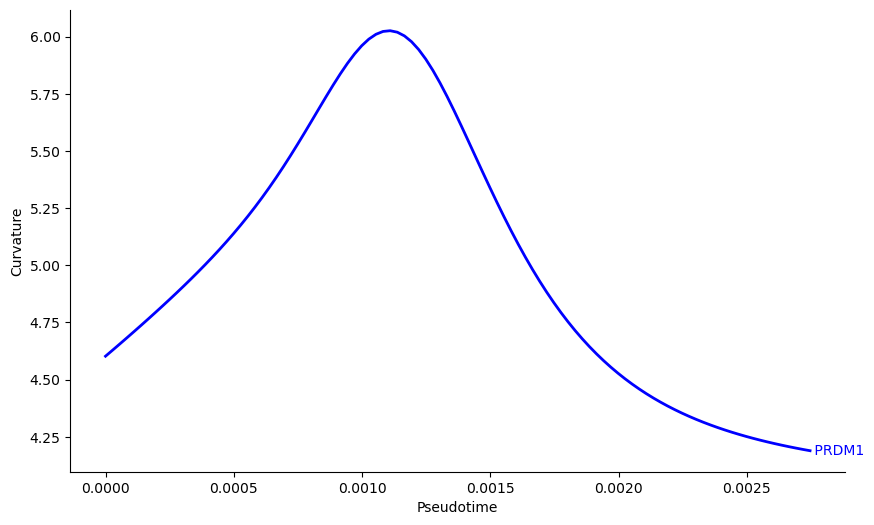

In [91]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['PRDM1']
colors = ['blue']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in lf_lcpm_dcurve_gc.index:
        line = plt.plot(dtime_gc, lf_lcpm_dcurve_gc.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_gc.iloc[-1], lf_lcpm_dcurve_gc.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Curvature')
plt.show()

# Regulations and beta characteristics

#### Get subnetworks for the dynamic genes in one lineage

In [85]:
pts, fsmooth = dictys_dynamic_object.linspace(1,3,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [86]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 100)

In [87]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [88]:
# save the dnet and dnetbin as npy 
np.save(os.path.join(output_folder, 'dnet_gc.npy'), dnet)
np.save(os.path.join(output_folder, 'dnetbin_gc.npy'), dnetbin)


In [5]:
# load the dnet and dnetbin
dnet = np.load(os.path.join(output_folder, 'dnet_pb.npy'))
dnetbin = np.load(os.path.join(output_folder, 'dnetbin_pb.npy'))

In [89]:
# get indices of the dynamic_pb_genes
lf_genes_indices = get_gene_indices(dictys_dynamic_object, lf_genes)
display(len(lf_genes_indices))  

68

In [90]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), lf_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 68, 100)

#### Filter TFs from the entire list (551)

In [91]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.01
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

201


In [92]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(TFs_to_keep_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(201, 68, 100)

#### Get beta curves for a lineage


In [93]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in lf_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve_gc = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve_gc.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                                 
AHR SUB1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    HLA-DPB1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    HLA-DPA1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SSR1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    CCSER2    0.032274  0.033326  0.034364  0.035378  0.036355  0.037285   

                time_6    time_7    time_8    time_9  ...   time_90  time_91  \
TF  Target                                            ...                      
AHR SUB1      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.00000   
    HLA-DPB1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.00000   
    HLA-DPA1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.00000   
    SSR1      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.00000   
    CCSER2    0.038155  0.038954  0.039672  0.040297  ...  0.045277  0.04414   

               time_92   time_93  time_94   time_95   time_96   time_97  \
TF  Target                                                                
AHR SUB1      0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
    HLA-DPB1  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
    HLA-DPA1  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
    SSR1      0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
    CCSER2    0.043009  0.041888  0.04078  0.039688  0.038614  0.037559   

               time_98   time_99  
TF  Target                        
AHR SUB1      0.000000  0.000000  
    HLA-DPB1  0.000000  0.000000  
    HLA-DPA1  0.000000  0.000000  
    SSR1      0.000000  0.000000  
    CCSER2    0.036525  0.035513  

[5 rows x 100 columns]

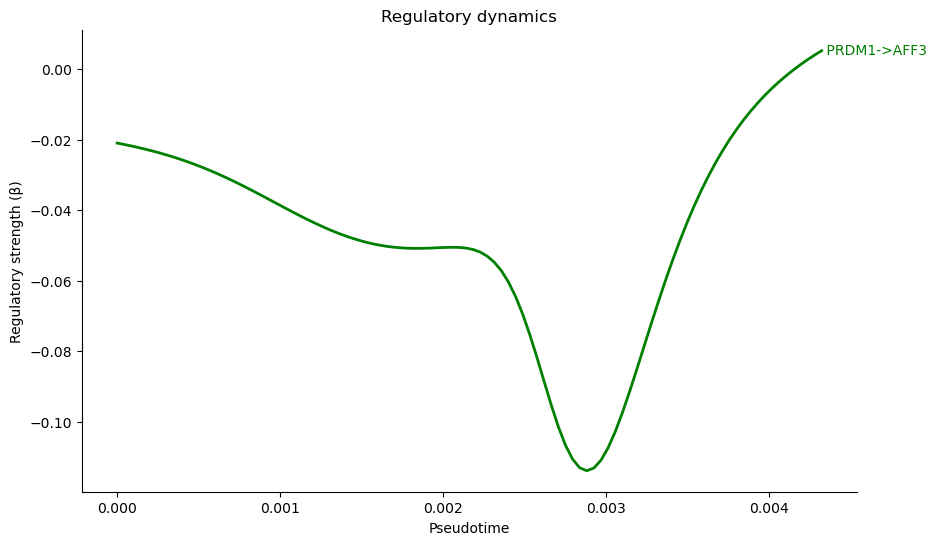

In [94]:
# Plot beta trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Specify TF-target pairs of interest
regulations_of_interest = [('PRDM1', 'AFF3')]
colors = ['green']   # Define colors for each regulation

for (tf, target), color in zip(regulations_of_interest, colors):
    # Create multi-index key for the regulation
    idx = pd.MultiIndex.from_tuples([(tf, target)])
    if (tf, target) in lf_beta_dcurve_gc.index:
        line = plt.plot(dtime_gc, lf_beta_dcurve_gc.loc[(tf, target)], 
                       linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_gc.iloc[-1], 
                lf_beta_dcurve_gc.loc[(tf, target)].iloc[-1], 
                f' {tf}->{target}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Regulatory strength (β)')
plt.title('Regulatory dynamics')
plt.show()

## Getting the top regulations for a geneset
### 1. Per-gene get the max force at each time-point to get the regulations that explain the gene's expression dynamics best. Directionality does not matter in this selection of the maximum force.

In [95]:
# get the tf_lcpms for the lineage
kept_tfs_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[kept_tf_names]
print(len(kept_tfs_lcpm_dcurve_gc))

201


In [45]:
def calculate_force_curves(beta_curves: pd.DataFrame, tf_expression: pd.Series) -> pd.DataFrame:
    """
    Calculate force curves using log transformation
    """
    # Count number of targets per TF from beta_curves multi-index
    targets_per_tf = beta_curves.index.get_level_values(0).value_counts()
    # Create a DataFrame with repeated TF expression values for each target
    expanded_tf_expr = pd.DataFrame(
        np.repeat(tf_expression.values, targets_per_tf.values, axis=0),  # Repeat each TF's row 30 times
        index=beta_curves.index,  # Use beta_curves' multi-index
        columns=beta_curves.columns
    )
    # Convert to numpy arrays for calculations
    beta_array = beta_curves.to_numpy()
    tf_array = expanded_tf_expr.to_numpy()
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    log_beta = np.log10(np.abs(beta_array) + epsilon)
    log_tf = np.log10(tf_array + epsilon)
    # Preserve signs from original beta values
    signs = np.sign(beta_array)
    # Calculate forces 
    force_array = signs * np.exp(log_beta + log_tf)
    # Convert back to DataFrame with original index/columns
    force_curves = pd.DataFrame(
        force_array, 
        index=beta_curves.index, 
        columns=beta_curves.columns
    )
    return force_curves

In [96]:
lf_forces_dcurve_gc = calculate_force_curves(lf_beta_dcurve_gc, kept_tfs_lcpm_dcurve_gc)
display(lf_forces_dcurve_gc.head())
display(lf_forces_dcurve_gc.shape)

time_0    time_1    time_2   time_3    time_4    time_5  \
TF  Target                                                                
AHR SUB1      0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
    HLA-DPB1  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
    HLA-DPA1  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
    SSR1      0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
    CCSER2    0.502853  0.509931  0.516817  0.52346  0.529809  0.535815   

                time_6    time_7    time_8    time_9  ...   time_90   time_91  \
TF  Target                                            ...                       
AHR SUB1      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    HLA-DPB1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    HLA-DPA1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    SSR1      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    CCSER2    0.541426  0.546597  0.551284  0.555448  ...  0.646416  0.639358   

               time_92  time_93   time_94   time_95   time_96   time_97  \
TF  Target                                                                
AHR SUB1      0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
    HLA-DPB1  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
    HLA-DPA1  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
    SSR1      0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
    CCSER2    0.632221  0.62503  0.617805  0.610566  0.603328  0.596104   

               time_98   time_99  
TF  Target                        
AHR SUB1      0.000000  0.000000  
    HLA-DPB1  0.000000  0.000000  
    HLA-DPA1  0.000000  0.000000  
    SSR1      0.000000  0.000000  
    CCSER2    0.588905  0.581741  

[5 rows x 100 columns]

(13668, 100)

In [97]:
# save the lf_forces_dcurve_pb as a pickle
lf_forces_dcurve_gc.to_pickle(os.path.join(output_folder, 'lf_forces_dcurve_gc.pkl'))
# load lf_forces_dcurve_pb from pickle
#lf_forces_dcurve_pb = pd.read_pickle(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'))


In [98]:
lf_force_curves_sorted_by_target = lf_forces_dcurve_gc.sort_index(level=1)
display(lf_force_curves_sorted_by_target.head())
display(lf_force_curves_sorted_by_target.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
TF,Target,,,,,,,,,,,,,,,,,,,,,
AHR,AFF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARID3B,AFF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARID5A,AFF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARNTL,AFF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATF3,AFF3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(13668, 100)

In [53]:
def find_max_force_per_target(force_df):
    """
    Find TFs exerting maximum absolute force per target at each timepoint
    Returns DataFrame with force trajectories ordered by time of maximum force
    """
    # Initialize dictionary to store results
    max_force_dict = {}
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    # Process each target
    for target in targets:
        # Get all TFs for this target using boolean indexing
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        # Store the max force TF indices for each timepoint
        max_force_indices = []
        for col in force_df.columns:
            # Find TF with max absolute force at this time point
            max_force_idx = target_data[col].abs().idxmax()
            max_force_indices.append(max_force_idx)
        # Get the force trajectories for these TFs
        max_force_trajectories = force_df.loc[max_force_indices]
        max_force_dict[target] = max_force_trajectories
    # Concatenate all target results
    result_df = pd.concat(max_force_dict.values())
    return result_df

def find_top_k_forces_per_target(force_df, k=5):
    """
    Find the top 5 TFs exerting maximum absolute force per target at each timepoint.
    Returns a DataFrame with force trajectories ordered by time of maximum force.
    """
    # Initialize dictionary to store results
    top_force_dict = {}
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Process each target
    for target in targets:
        # Get all TFs for this target using boolean indexing
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Store the top 5 force TF indices for each timepoint
        top_force_indices = []
        for col in force_df.columns:
            # Get indices of the top 5 TFs with max absolute force at this time point
            top_force_idx = target_data[col].abs().nlargest(k).index
            top_force_indices.extend(top_force_idx)
        
        # Get the force trajectories for these TFs
        top_force_trajectories = force_df.loc[top_force_indices]
        top_force_dict[target] = top_force_trajectories
    
    # Concatenate all target results
    result_df = pd.concat(top_force_dict.values())
    return result_df

In [99]:
# Get max force
max_force_trajectories = find_top_k_forces_per_target(lf_force_curves_sorted_by_target, k=5)

In [100]:
display(max_force_trajectories.head())
display(max_force_trajectories.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
TF,Target,,,,,,,,,,,,,,,,,,,,,
IKZF1,AFF3,1.186406,1.169443,1.151545,1.132720,1.112990,1.092393,1.070980,1.048820,1.025998,1.002616,...,0.480818,0.481846,0.482764,0.483591,0.484341,0.485029,0.485667,0.486265,0.486832,0.487376
SPIB,AFF3,1.017341,1.004065,0.989310,0.973013,0.955120,0.935593,0.914408,0.891563,0.867074,0.840983,...,-0.253452,-0.275524,-0.293358,-0.308078,-0.320405,-0.330836,-0.339732,-0.347365,-0.353945,-0.359642
TCF12,AFF3,0.972812,0.974842,0.977235,0.980033,0.983275,0.987002,0.991256,0.996075,1.001492,1.007538,...,0.943453,0.949162,0.954218,0.958675,0.962577,0.965969,0.968888,0.971368,0.973443,0.975142
ZNF846,AFF3,0.839053,0.826388,0.813019,0.798946,0.784174,0.768719,0.752607,0.735875,0.718570,0.700751,...,-0.484319,-0.487462,-0.490397,-0.493145,-0.495725,-0.498154,-0.500444,-0.502607,-0.504651,-0.506585
TCF4,AFF3,0.831160,0.822632,0.813139,0.802624,0.791029,0.778305,0.764404,0.749285,0.732912,0.715255,...,-0.436713,-0.403230,-0.369078,-0.333765,-0.296530,-0.256075,-0.209791,-0.150554,0.041885,0.151829


(34000, 100)

In [101]:
def get_unique_regs_by_target(max_force_df):
    """
    Create dictionary of unique TF-target pairs for each target
    """
    # Get unique targets
    targets = max_force_df.index.get_level_values(1).unique()
    # Initialize dictionary
    tf_target_pairs_per_gene = {}
    # Process each target
    for target in targets:
        # Get rows for this target
        target_mask = max_force_df.index.get_level_values(1) == target
        target_data = max_force_df[target_mask]
        # Get unique TFs for this target
        unique_tfs = target_data.index.get_level_values(0).unique()
        # Create list of tuples
        tf_target_pairs = [(str(tf), str(target)) for tf in unique_tfs]
        # Store in dictionary
        tf_target_pairs_per_gene[target] = tf_target_pairs
    return tf_target_pairs_per_gene

In [102]:
lf_gene_regulations = get_unique_regs_by_target(max_force_trajectories)
# Get all unique TFs
all_tfs = set(tf for regs in lf_gene_regulations.values() 
                for tf, _ in regs)

# Create dictionary of TF -> list of targets
tf_to_targets = {}
for tf in all_tfs:
    # Find all targets regulated by this TF
    targets = [target for target, regs in lf_gene_regulations.items() 
                if any(reg[0] == tf for reg in regs)]
    tf_to_targets[tf] = targets
print(tf_to_targets)
print(len(all_tfs))
print(sum(len(values) for values in tf_to_targets.values()))

{'BATF': ['HLA-DMA', 'HLA-DPA1', 'HLA-DPB1', 'IQGAP2'], 'TFEB': ['PRDM1'], 'IRF1': ['B2M', 'CIITA', 'CTSH', 'HLA-A', 'HLA-B', 'HLA-DMA', 'HLA-DMB', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'RNF213', 'UBAC2'], 'ZNF101': ['CTSH', 'IGHM'], 'STAT2': ['B2M', 'MZB1'], 'NRF1': ['AFF3', 'ANKRD28', 'ARFGAP3', 'ARNTL2', 'B2M', 'CD52', 'CD79A', 'CD99', 'CEP128', 'CIITA', 'CTSH', 'EEA1', 'FNDC3A', 'GAB1', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HM13', 'IRF4', 'MZB1', 'PAX5', 'PIM2', 'PPIB', 'RUNX2', 'SLAMF7', 'SUB1', 'TBC1D4', 'TIAM1', 'TRAM1', 'TRAM2', 'TXNDC11', 'TXNDC5', 'XBP1'], 'LIN54': ['ANKRD28', 'CDK6', 'HLA-C', 'HM13', 'MED23', 'SLAMF7', 'TNFAIP8'], 'ZBTB44': ['FNDC3B', 'MED23'], 'SOX5': ['CD74', 'DEK', 'PDE4D'], 'YY1': ['CCSER2', 'CD52', 'CD74', 'CPEB4', 'CTSH', 'DEK', 'HLA-DMA', 'HLA-DPA1', 'HLA-DPB1', 'XBP1'], 'MLXIP': ['HSP90B1', 'LMAN1', 'SSR1'], 'ARID5A': ['HLA-DRA', 'IGHM', 'PIKFYVE', 'SLAMF7'], 

In [103]:
# save tf_to_targets as a pickle
import pickle
with open(os.path.join(output_folder, 'top_5_TFs_per_target_gc.pkl'), 'wb') as f:
    pickle.dump(tf_to_targets, f)


In [57]:
def plot_force_heatmap(
    force_df: pd.DataFrame,
    dtime: pd.Series,
    regulations=None,
    tf_to_targets_dict=None,
    ax: Optional[matplotlib.axes.Axes] = None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = 'coolwarm',
    figsize: Tuple[float, float] = (10, 4),
    vmax: Optional[float] = None
) -> Tuple[matplotlib.pyplot.Figure, matplotlib.axes.Axes, np.ndarray]:
    """
    Draws pseudo-time dependent heatmap of force values.
    """
    # Process input parameters to generate regulation pairs
    reg_pairs = []
    reg_labels = []
    
    # Case 1: Dictionary of TF -> targets provided
    if tf_to_targets_dict is not None:
        for tf, targets in tf_to_targets_dict.items():
            for target in targets:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
    
    # Case 2: List of regulation pairs or list of targets for a single TF
    elif regulations is not None:
        # Check if first item is a string (target) or tuple/list (regulation pair)
        if regulations and isinstance(regulations[0], str):
            # It's a list of targets for a single TF
            # Extract TF name from the calling context (not ideal but works for the notebook)
            for key, value in locals().items():
                if isinstance(value, dict) and 'PRDM1' in value and value['PRDM1'] == regulations:
                    tf = 'PRDM1'  # Found the TF
                    break
            else:
                # If we can't determine the TF, use the first item in regulations as TF
                # and the rest as targets (this is a fallback and might not be correct)
                tf = regulations[0]
                regulations = regulations[1:]
            
            for target in regulations:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
        else:
            # It's a list of regulation pairs
            reg_pairs = regulations
            reg_labels = [f"{tf}->{target}" for tf, target in regulations]
    
    # If no regulations provided, use non-zero regulations from force_df
    if not reg_pairs:
        non_zero_mask = (force_df != 0).any(axis=1)
        force_df_filtered = force_df[non_zero_mask]
        reg_pairs = list(force_df_filtered.index)
        reg_labels = [f"{tf}->{target}" for tf, target in reg_pairs]
    
    # Extract force values for the specified regulations
    force_values = []
    for pair in reg_pairs:
        tf, target = pair
        try:
            force_values.append(force_df.loc[(tf, target)].values)
        except KeyError:
            raise ValueError(f"Regulation {tf}->{target} not found in force DataFrame")
    
    # Convert to numpy array
    dnet = np.array(force_values)
    
    # Create figure and axes
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    
    # Determine and apply colormap
    if isinstance(cmap, str):
        if vmax is None:
            vmax = np.quantile(np.abs(dnet).ravel(), 0.95)
        cmap = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax), 
            cmap=cmap
        )
    elif vmax is not None:
        raise ValueError("vmax should not be set if cmap is a matplotlib.cm.ScalarMappable.")
    
    if hasattr(cmap, "to_rgba"):
        im = ax.imshow(cmap.to_rgba(dnet), aspect='auto', interpolation='none')
    else:
        im = ax.imshow(dnet, aspect='auto', interpolation='none', cmap=cmap)
        plt.colorbar(im, label="Force")
    
    # Set pseudotime labels
    ax.set_xlabel("Pseudotime")
    num_ticks = 10
    tick_positions = np.linspace(0, dnet.shape[1] - 1, num_ticks, dtype=int)
    tick_labels = dtime.iloc[tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f"{x:.4f}" for x in tick_labels], rotation=45, ha="right")
    
    # Set regulation pair labels
    ax.set_yticks(list(range(len(reg_labels))))
    ax.set_yticklabels(reg_labels)
    
    # Add grid lines
    ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
    
    plt.tight_layout()
    return fig, ax, dnet

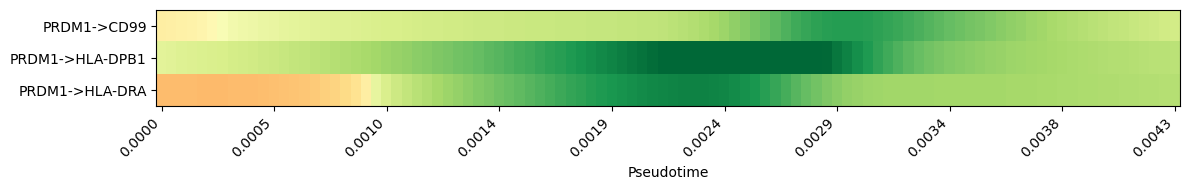

In [109]:
fig, ax, force_values = plot_force_heatmap(
    force_df=lf_forces_dcurve_gc,
    dtime=dtime_gc,
    tf_to_targets_dict={'PRDM1': tf_to_targets['PRDM1']},
    figsize=(12, 2),
    cmap='RdYlGn'
)